# Preparing the Data

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/car_ims.tgz

In [1]:
data_directory = "cars_data"
train_images = "cars_data/cars_train"

In [2]:
import pandas as pd

train_df = pd.read_csv("cars_data/database/cars_train_data.csv")

train_df.head()

,Unnamed: 0,x1,y1,x2,y2,Class,image
0,0,39,116,569,375,14,00001.jpg
1,1,36,116,868,587,3,00002.jpg
2,2,85,109,601,381,91,00003.jpg
3,3,621,393,1484,1096,134,00004.jpg
4,4,14,36,133,99,106,00005.jpg


# Resizing Images Using PyTorch

In [3]:
import os
from PIL import Image
from torchvision import transforms

# Needed input dimensions for the CNN
input_dim = (224, 224)
input_dir_cnn = data_directory + "/images/input_images_cnn"

os.makedirs(input_dir_cnn, exist_ok=True)

transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])

for image_name in os.listdir(train_images):
    I = Image.open(os.path.join(train_images, image_name))
    newI = transformation_for_cnn_input(I)
    
    newI.save(os.path.join(input_dir_cnn, image_name))
    
    newI.close()
    I.close()

# Image Embeddings

In [4]:
import torch
from torchvision import models


class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device('cpu')
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
    
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        
        def copyData(m, i, o):
            embedding.copy_(o.data)
            
        h = self.featureLayer.register_forward_hook(copyData)
        h_x = self.model(image)
        h.remove()
        
        return embedding.numpy()[0, :, 0, 0]

In [ ]:
# Option first
import tqdm

img2vec = Img2VecResnet18()
allVectors = {}

for image in tqdm(os.listdir(input_dir_cnn)):
    I = Image.open(os.path.join(input_dir_cnn, image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close()

In [ ]:
# Option second
from tqdm import tqdm  # Importar a classe tqdm diretamente do módulo tqdm
import os
from PIL import Image

img2vec = Img2VecResnet18()
allVectors = {}

for image in tqdm(os.listdir(input_dir_cnn)):  # Usar a classe tqdm
    I = Image.open(os.path.join(input_dir_cnn, image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close()


In [8]:
# Option third
from tqdm import tqdm
import os
from PIL import Image

img2vec = Img2VecResnet18()
allVectors = {}

for image in tqdm(os.listdir(input_dir_cnn)):
    I = Image.open(os.path.join(input_dir_cnn, image))

    # Converter a imagem para RGB, se necessário
    if I.mode != 'RGB':
        I = I.convert('RGB')

    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close()


D:\WorkSpace\Github\Advanced_Analytics_With_Pyspark\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\WorkSpace\Github\Advanced_Analytics_With_Pyspark\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 8144/8144 [15:38<00:00,  8.68it/s]  


In [9]:
import pandas as pd

data_folder = "cars_data/output"

pd.DataFrame(allVectors).transpose(). \
    to_csv(data_folder + "/input_data_vectors.csv")

# Import Image Embeddings into PySpark

In [10]:
#!pip install pyspark
import pyspark

from pyspark.sql import SparkSession

In [11]:
spark = SparkSession.builder.config("spark.driver.memory", "8g").appName('chapter_10').getOrCreate()

In [12]:
input_df = spark.read.option("inferSchema", "true"). \
    csv(data_folder + "/input_data_vectors.csv", header=True)

input_df.columns

['_c0',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137'

In [16]:
from pyspark.ml.feature import VectorAssembler

vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

output = assembler.transform(input_df)
output = output.select('_c0', 'features')

output.show(1, vertical=True)

-RECORD 0------------------------
 _c0      | 00001.jpg            
 features | [0.46972847,3.713... 
only showing top 1 row



In [15]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



# Image Similarity Search Using PySpark LSH

In [17]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", numHashTables=200, bucketLength=2.0)
model = brp.fit(output)

In [18]:
lsh_df = model.transform(output)
lsh_df.show(5)

+---------+--------------------+--------------------+
|      _c0|            features|              hashes|
+---------+--------------------+--------------------+
|00001.jpg|[0.46972847,3.713...|[[-1.0], [-1.0], ...|
|00002.jpg|[0.6601969,2.9731...|[[-1.0], [-1.0], ...|
|00003.jpg|[0.7625084,1.7897...|[[-1.0], [-1.0], ...|
|00004.jpg|[1.1646781,2.3180...|[[0.0], [-1.0], [...|
|00005.jpg|[0.7852023,0.9928...|[[-1.0], [-1.0], ...|
+---------+--------------------+--------------------+
only showing top 5 rows



# Nearest Neighbor Search

cars_data/images/input_images_cnn\00001.jpg


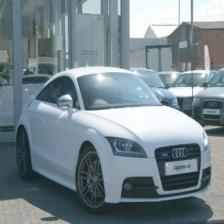

In [20]:
from IPython.display import Image
from PIL import Image

input_dir_cnn = data_directory + "/images/input_images_cnn"

teste_image = os.listdir(input_dir_cnn)[0]
teste_image = os.path.join(input_dir_cnn, teste_image)
print(teste_image)
display(Image.open(teste_image))

In [21]:
img2vec = Img2VecResnet18()
I = Image.open(teste_image)
teste_vec = img2vec.getVec(I)
I.close()

print(len(teste_vec))
print(teste_vec)

D:\WorkSpace\Github\Advanced_Analytics_With_Pyspark\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\WorkSpace\Github\Advanced_Analytics_With_Pyspark\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
[4.69728470e-01 3.71329355e+00 3.79811263e+00 2.41941646e-01
 2.00141382e+00 9.95017827e-01 7.71624327e-01 1.31081343e+00
 4.00244176e-01 7.75701821e-01 4.62536126e-01 1.68167189e-01
 2.86844850e-01 8.31929862e-01 2.06048861e-01 7.07891285e-01
 5.77547193e-01 1.96115926e-01 4.45372045e-01 5.30471444e-01
 5.04827619e-01 2.08376098e+00 6.56139195e-01 2.66508222e-01
 5.82561195e-01 1.13171077e+00 7.09854603e-01 1.73194695e+00
 2.60290325e-01 9.34019148e-01 1.72895685e-01 9.42930639e-01
 4.29267645e+00 9.41597939e-01 3.55749339e-01 5.14600158e-01
 2.54955798e-01 8.98595095e-01 9.54963148e-01 2.39574626e-01
 7.60058165e-01 1.44357216e+00 1.33005917e+00 8.87622833e-01
 5.24353981e-01 1.00485671e+00 4.33427930e-01 0.00000000e+00
 7.28711367e-01 2.47075006e-01 9.97525752e-01 2.23030597e-01
 5.33861220e-01 4.30323780e-01 1.54944241e-01 3.40875119e-01
 1.02995205e+00 1.06890369e-02 8.47492933e-01 1.02637494e+00
 2.75209159e-01 4.36915338e-01 1.00126779e+00 1.77927405e-01
 6.58466101e-01 1.45

In [22]:
from pyspark.ml.linalg import Vectors

teste_vector = Vectors.dense(teste_vec)

In [23]:
print("Approximately searching lsh_df for 5 nearest neighbors of the input vector:")

result = model.approxNearestNeighbors(output, teste_vector, 5)

result.show()

Approximately searching lsh_df for 5 nearest neighbors of the input vector:
+---------+--------------------+--------------------+--------------------+
|      _c0|            features|              hashes|             distCol|
+---------+--------------------+--------------------+--------------------+
|00001.jpg|[0.46972847,3.713...|[[-1.0], [-1.0], ...|4.214741468365922E-7|
|07168.jpg|[0.95363134,4.393...|[[-1.0], [-1.0], ...|   9.315957520737076|
|06451.jpg|[0.5470275,2.9539...|[[-1.0], [-1.0], ...|   9.867781424610602|
|05580.jpg|[0.8154126,3.2295...|[[0.0], [-1.0], [...|  10.059118358705458|
|00312.jpg|[0.836261,4.18430...|[[-1.0], [-1.0], ...|  10.471624815773843|
+---------+--------------------+--------------------+--------------------+



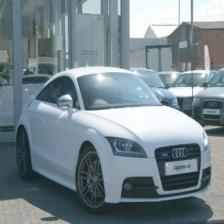

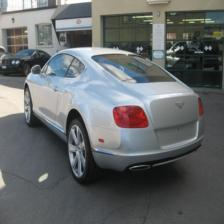

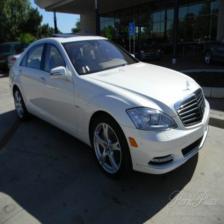

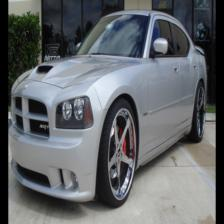

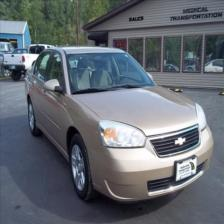

In [24]:
for i in list(result.select("_c0").toPandas()["_c0"]):
    display(Image.open(os.path.join(input_dir_cnn, i)))